# 10. 시각화
## 10.1 설명 가능한 인공지능

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
cd/content/gdrive/My Drive/pytorch_dlbro

/content/gdrive/My Drive/pytorch_dlbro


In [4]:
# GPU vs CPU
# 현재 가능한 장치를 확인한다.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
transform = transforms.Compose([transforms.Resize(128), transforms.ToTensor()])
trainset = torchvision.datasets.STL10(root='./data', split='train', download=True, transform=transform) # 96x96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

testset = torchvision.datasets.STL10(root='./data', split='test', download=True, transform=transform) # 96x96
testloader = torch.utils.data.DataLoader(testset, batch_size=40, shuffle=True)
# 10 classes: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

Files already downloaded and verified
Files already downloaded and verified


In [6]:
model = torchvision.models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 512개
model.fc = nn.Linear(num_ftrs, 10) # fc를 nn.Linear(num_ftrs, 10)로 대체한다.
model = model.to(device)

In [7]:
model.load_state_dict(torch.load('./models/stl10_resnet18.pth'))

<All keys matched successfully>

In [8]:
def acc(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.detach(), 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy: %d %%' % (100 * correct / total))

In [9]:
acc(trainloader)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Accuracy: 99 %


In [10]:
acc(testloader)

Accuracy: 86 %


In [11]:
# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [12]:
def cam(dataset, img_sample, img_size):
    model.eval()
    with torch.no_grad(): # requires_grad 비활성화

        model.layer4[1].bn2.register_forward_hook(get_activation('final')) # feature extraction의 마지막 feature map 구하기
        data, label = dataset[img_sample] # 이미지 한 장과 라벨 불러오기
        data.unsqueeze_(0) # 4차원 3차원 [피쳐수 ,너비, 높이] -> [1,피쳐수 ,너비, 높이]
        output = model(data.to(device))
        _, prediction = torch.max(output, 1)
        act = activation['final'].squeeze() # 4차원 [1,피쳐수 ,너비, 높이] -> 3차원 [피쳐수 ,너비, 높이]
        w = model.fc.weight # classifer의 가중치 불러오기
        
        for idx in range(act.size(0)): # CAM 연산
            if idx == 0:
                tmp = act[idx] * w[prediction.item()][idx] 
            else:
                tmp += act[idx] * w[prediction.item()][idx]

        # 모든 이미지 팍셀값을 0~255로 스케일하기 
        normalized_cam = tmp.cpu().numpy()
        normalized_cam = (normalized_cam - np.min(normalized_cam)) / (np.max(normalized_cam) - np.min(normalized_cam))
        original_img = np.uint8((data[0][0] / 2 + 0.5) * 255)

        # 원본 이미지 사이즈로 리사이즈
        cam_img = cv2.resize(np.uint8(normalized_cam * 255), dsize=(img_size, img_size)) 
        
    return cam_img, original_img, prediction, label

In [13]:
def plot_cam(dataset, img_size, start):
    end = start + 20
    fig, axs = plt.subplots(2, (end - start + 1) // 2, figsize=(20, 4))
    fig.subplots_adjust(hspace=.01, wspace=.01)
    axs = axs.ravel()
    cls = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']
    for i in range(start, end):
        
        cam_img, original_img, prediction, label = cam(dataset, i, img_size)
        if prediction == label:
            color = 'white'
        else: 
            color = 'red'   
        axs[i - start].imshow(original_img, cmap='gray')
        axs[i - start].imshow(cam_img, cmap='jet', alpha=.4)
        axs[i - start].text(5, 5, cls[prediction], bbox={'facecolor': color, 'pad': 5})
        axs[i - start].axis('off')
        
    plt.show()
    #fig.savefig('cam.png')

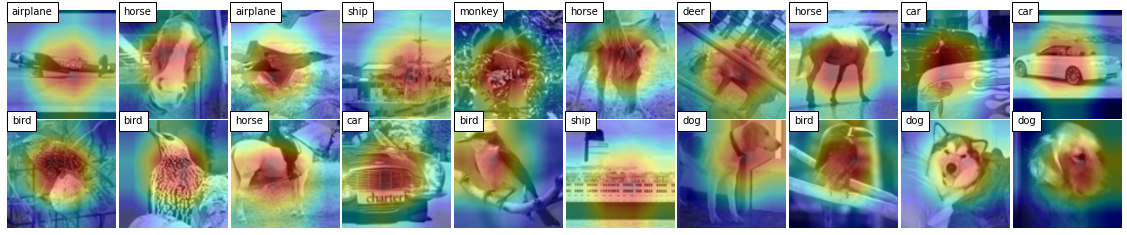

In [14]:
plot_cam(trainset, 128, 10)

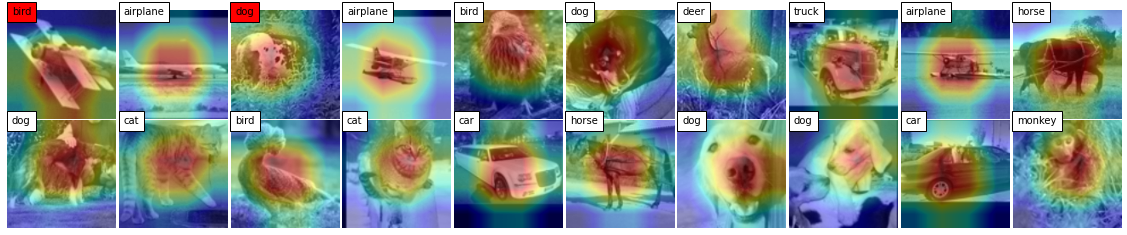

In [15]:
plot_cam(testset, 128, 10)